In [1]:
import pandas as pd

df = pd.read_csv('escooter_data.csv')
df = df.dropna(subset=['Start Centroid Longitude', 'End Centroid Longitude'])
df.head()

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Accuracy,Start Census Tract,End Census Tract,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location
10291,0dd95046-1bc8-4464-ba39-7f9e92c668b3,08/06/2019 06:00:00 PM,08/06/2019 06:00:00 PM,1004,236,152,1.703120e+10,1.703120e+10,20.0,20.0,HERMOSA,HERMOSA,41.935048,-87.737604,POINT (-87.7376041954734 41.9350481285613),41.935048,-87.737604,POINT (-87.7376041954734 41.9350481285613)
10293,6819df6a-9623-4ae0-b1d3-ec617197d229,07/08/2019 04:00:00 PM,07/08/2019 05:00:00 PM,9124,3182,10,1.703115e+10,1.703119e+10,15.0,19.0,PORTAGE PARK,BELMONT CRAGIN,41.949592,-87.761958,POINT (-87.7619580301513 41.9495915671753),41.920143,-87.760827,POINT (-87.7608269556143 41.920143229102)
10342,aa71bb53-3e7f-4964-b6e6-030800419346,08/10/2019 09:00:00 PM,08/10/2019 09:00:00 PM,502,97,152,1.703184e+10,1.703184e+10,27.0,27.0,EAST GARFIELD PARK,EAST GARFIELD PARK,41.885045,-87.713862,POINT (-87.71386248059811 41.8850448415253),41.885045,-87.713862,POINT (-87.71386248059811 41.8850448415253)
10367,5d256770-1a8a-5e20-8f78-316d1819f46b,06/25/2019 07:00:00 PM,06/25/2019 08:00:00 PM,5053,2167,0,1.703122e+10,1.703119e+10,22.0,19.0,LOGAN SQUARE,BELMONT CRAGIN,41.921126,-87.699754,POINT (-87.6997540616386 41.9211256768265),41.927819,-87.751362,POINT (-87.7513623675995 41.9278186319205)
10369,dffe5324-5f6f-48e7-9edf-d51876ba7d2f,09/19/2019 08:00:00 AM,09/19/2019 08:00:00 AM,790,111,152,1.703119e+10,1.703120e+10,19.0,20.0,BELMONT CRAGIN,HERMOSA,41.935218,-87.744389,POINT (-87.7443888733072 41.9352176386575),41.927852,-87.735628,POINT (-87.7356282729632 41.9278522690551)


In [2]:
from tqdm.notebook import tqdm
import pandas as pd

df['Start Time'] = pd.to_datetime(df['Start Time'], format='%m/%d/%Y %I:%M:%S %p')
df['End Time'] = pd.to_datetime(df['End Time'], format='%m/%d/%Y %I:%M:%S %p')
df.sort_values(by='Start Time', inplace=True)

Q1 = df['Trip Duration'].quantile(0.25)
Q3 = df['Trip Duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['Trip Duration'] >= lower_bound) & (df['Trip Duration'] <= upper_bound)]

end_location_to_escooter_id = {}

hourly_cumulative_distance = {}

for date, group in tqdm(df.groupby(df['Start Time'].dt.date), desc="Processing Days"):
    e_id = 1
    end_location_to_escooter_id.clear()

    for index, row in group.iterrows():
        start_location = row['Start Centroid Location']
        end_location = row['End Centroid Location']
        trip_distance = row['Trip Duration']
        trip_end_hour = row['End Time'].hour

        if start_location in end_location_to_escooter_id:
            scooter_id = end_location_to_escooter_id[start_location]
        else:
            scooter_id = e_id
            e_id += 1

        hourly_cumulative_distance.setdefault((scooter_id, trip_end_hour), 0)
        hourly_cumulative_distance[(scooter_id, trip_end_hour)] += trip_distance

        end_location_to_escooter_id[end_location] = scooter_id

average_distances = {}
for (scooter_id, hour), distance in hourly_cumulative_distance.items():
    average_distances.setdefault(hour, []).append(distance)

average_distances = {hour: sum(distances) / len(distances) for hour, distances in average_distances.items()}

Processing Days:   0%|          | 0/111 [00:00<?, ?it/s]

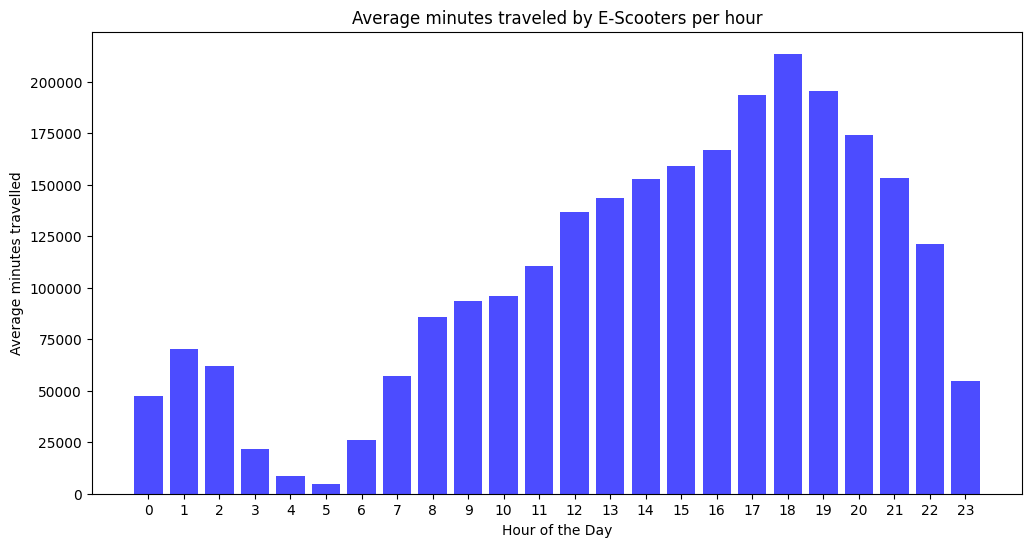

In [3]:
import matplotlib.pyplot as plt

hours = list(average_distances.keys())
avg_distances = list(average_distances.values())

plt.figure(figsize=(12, 6))
plt.bar(hours, avg_distances, color='blue', alpha=0.7)
plt.xlabel('Hour of the Day')
plt.ylabel('Average minutes travelled')
plt.title('Average minutes traveled by E-Scooters per hour')
plt.xticks(hours)

plt.show()


In [4]:
import pickle

average_distances = {hour: avg_distance for hour, avg_distance in zip(hours, avg_distances)}

with open('distributions/average_distance_per_hour.pkl', 'wb') as f:
    pickle.dump(average_distances, f)

In [19]:
average_distances

{5: 4672.458333333333,
 6: 23909.117647058825,
 8: 85773.12328767123,
 7: 57326.25,
 10: 100075.39583333333,
 9: 94438.72527472528,
 11: 115958.09322033898,
 12: 141645.05555555556,
 14: 155807.20942408376,
 13: 153699.2951807229,
 15: 164722.7263681592,
 21: 148425.24774774775,
 16: 174689.18779342723,
 17: 198612.46575342465,
 19: 196331.8169642857,
 20: 180347.6513761468,
 18: 215433.80995475114,
 22: 117742.5512195122,
 23: 53902.20338983051,
 0: 48032.28301886792,
 1: 71539.22222222222,
 2: 63694.25,
 3: 23097.055555555555,
 4: 8490.0}